In [303]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
from myFunctions import install_packages, save_table 
install_packages()


Installing required packages: ['numpy', 'pandas', 'scikit-learn', 'joblib', 'pyarrow', 'fastparquet', 'plotly', 'matplotlib', 'seaborn', 'MetaTrader5', 'tabulate', 'optuna', 'torch', 'tqdm', 'shap', 'kaleido', 'statsmodels', 'tqdm']
numpy is already installed.
pandas is already installed.
scikit-learn is already installed.
joblib is already installed.
pyarrow is already installed.
fastparquet is already installed.
plotly is already installed.
matplotlib is already installed.
seaborn is already installed.
MetaTrader5 is already installed.
tabulate is already installed.
optuna is already installed.
torch is already installed.
tqdm is already installed.
shap is already installed.
kaleido is already installed.
statsmodels is already installed.
tqdm is already installed.
All packages are verified.


In [304]:
from tabulate import tabulate
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.importance import get_param_importances
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

In [305]:
def extract_param_importances(input_dir_processed, folder_name):
    """
    Extracts parameter importances from .pkl files within a specified folder and saves the results to a CSV file.
    Additionally, reads the best trial index and value from '_best_params.pkl' files.
    
    Parameters:
    input_dir_processed (str): The root directory containing the hyperparameter folders.
    folder_name (str): The specific folder (e.g., 'D1') to process.
    """
    path = os.path.join(input_dir_processed, folder_name)
    importances_list = []
    best_params_list = []
    
    # Loop through all files in the folder
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('study.pkl'):
                    # Regex to extract model, look_back, look_forward, and target from file name
                    model_match = re.search(r'(CNN-GRU|LSTM|GRU|CNN-LSTM)', file_name)
                    look_back_match = re.search(r'look_back_(\d+)', file_name)
                    look_forward_match = re.search(r'look_forward_(\d+)', file_name)
                    target_match = re.search(r'(behavior|close_price|open_price)', file_name)
                    
                    if model_match and look_back_match and look_forward_match and target_match:
                        model = model_match.group(1)
                        look_back = int(look_back_match.group(1))
                        look_forward = int(look_forward_match.group(1))
                        target = target_match.group(1)
                        
                        # Create a model code string for identification
                        model_code = f"{model}_LB{look_back}_LF{look_forward}_{target}"
                        
                        # Load the .pkl file containing parameter importances
                        file_path = os.path.join(folder_path, file_name)
                        study = joblib.load(file_path)
                        importances = get_param_importances(study)
                        
                        # Create DataFrame from the importances and add model details
                        importances_df = pd.DataFrame(list(importances.items()), columns=['Parameter', 'Importance'])
                        importances_df.rename(columns={'Parameter': 'Index'}, inplace=True)
                        importances_df['model_code'] = model_code
                        importances_df['model'] = model
                        importances_df['target'] = target
                        importances_df['LB'] = look_back
                        
                        # Load the best_params.pkl file to get additional hyperparameter information
                        best_params_file = file_name.replace('study.pkl', 'best_params.pkl')
                        best_params_path = os.path.join(folder_path, best_params_file)
                        best_params_data = joblib.load(best_params_path)

                        best_params = best_params_data['best_params']
                        # Create a DataFrame from best_params and add best trial details
                        df_best_params = pd.DataFrame([best_params])
                        df_best_params['model_code'] = model_code
                        df_best_params['best_trial_index'] = best_params_data['best_trial_index']
                        df_best_params['best_trial_value'] = best_params_data['best_trial_value']


                        # Append the importances DataFrame to the list for later combination
                        importances_list.append(importances_df)
                        best_params_list.append(df_best_params)
    
    # Combine all importances into one DataFrame and pivot it to organize by parameters
    all_importances_df = pd.concat(importances_list, ignore_index=True)
    all_best_params = pd.concat(best_params_list, ignore_index=True)

    # Define the columns to be used for grouping and identifying each record
    ids = [
        'model_code', 'model', 'LB', 'target'
    ]    
    # Pivot the DataFrame to have parameters as columns and importances as values
    hyperparameters_df = all_importances_df.pivot_table(index=ids, columns='Index', values='Importance', aggfunc='first')   

    # Reset index to make the DataFrame more accessible
    hyperparameters_df.reset_index(inplace=True)
    all_best_params.reset_index(inplace=True)

    return hyperparameters_df, all_best_params

In [306]:

input_dir_processed = os.path.join('..', 'hyperparameters')
hyperparameters_df, all_best_params = extract_param_importances(input_dir_processed, 'D1')



In [307]:
hyperparameters_df.reset_index(inplace=True)

In [308]:
all_best_params = all_best_params[['model_code', 'best_trial_value', 'epochs', 'batch_size', 'learning_rate', 'dropout', 'num_layers', 'hidden_size', 'conv_filters', 'best_trial_index']]


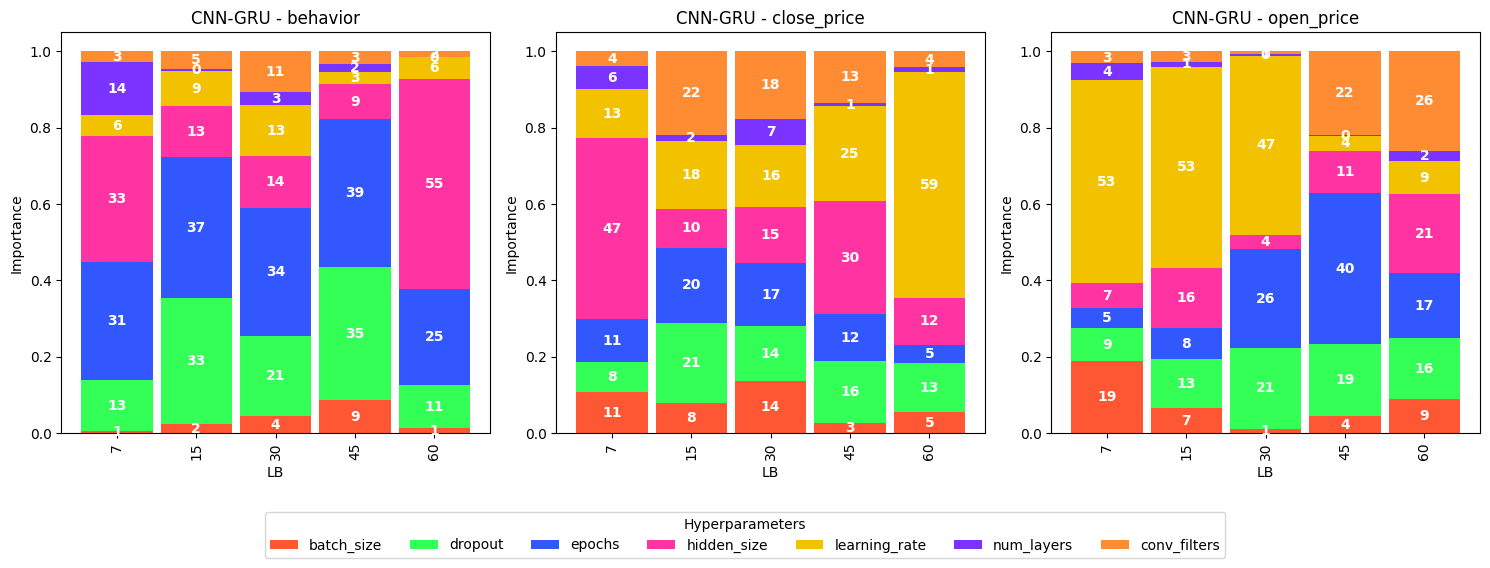

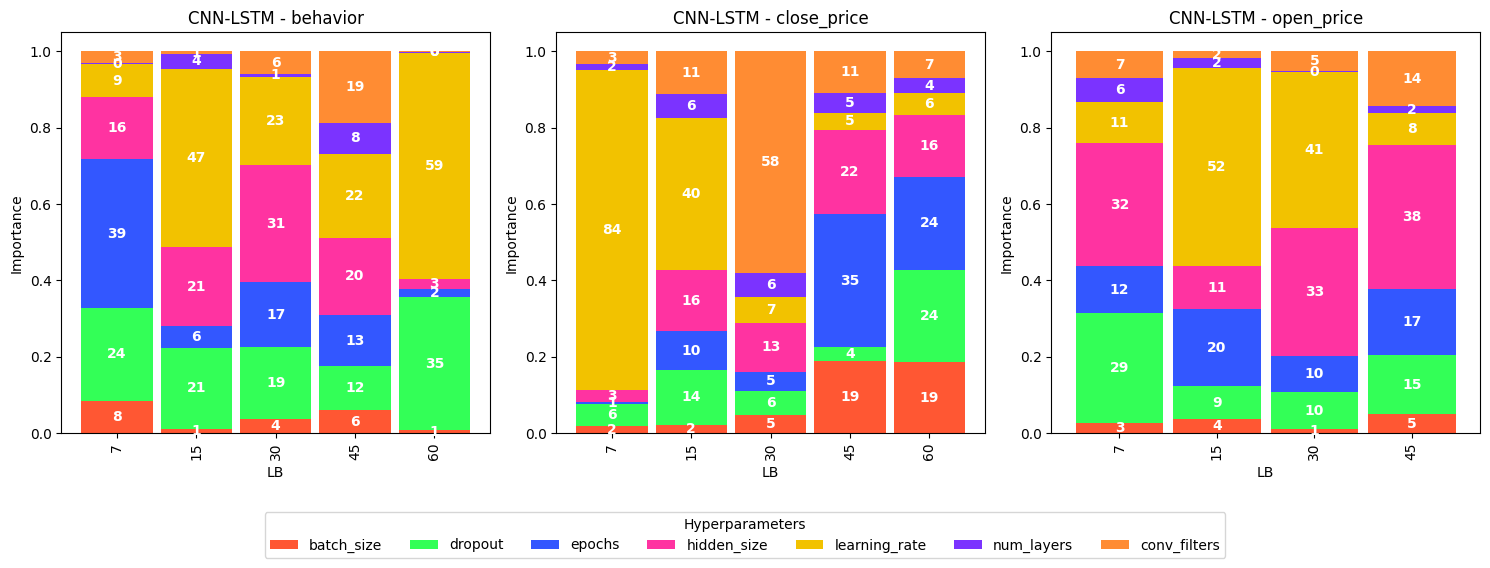

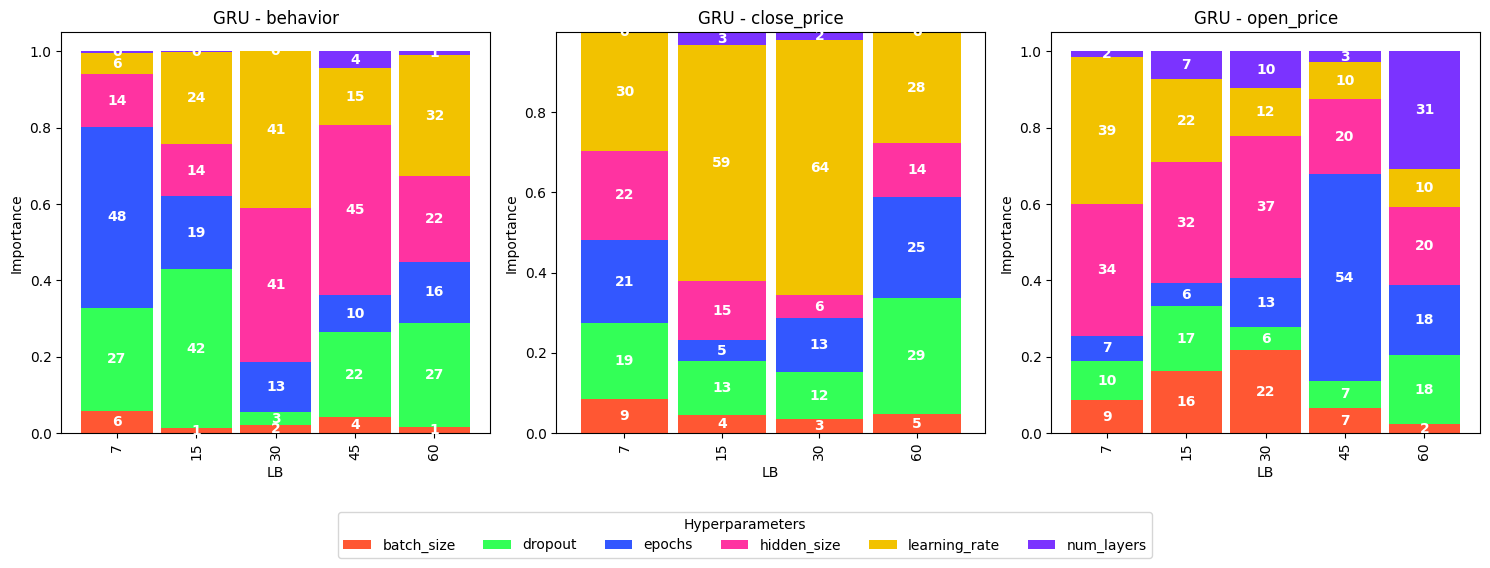

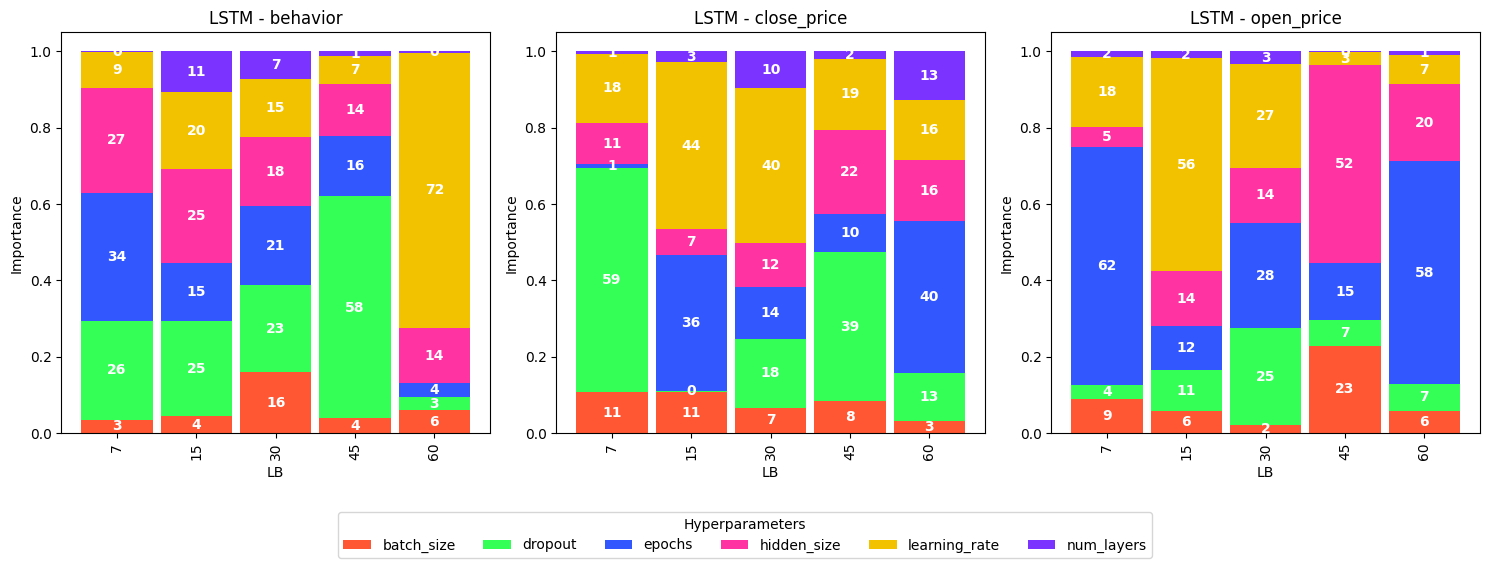

In [309]:
for idx, model in enumerate(hyperparameters_df['model'].unique()):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    handles = []
    labels = []

    for i, target in enumerate(hyperparameters_df['target'].unique()):
        mask = (hyperparameters_df['model'] == model) & (hyperparameters_df['target'] == target)
        df_aux = hyperparameters_df[mask]

        if 'CNN' not in model:
            df_aux = df_aux[['LB', 'batch_size', 'dropout', 'epochs', 'hidden_size', 'learning_rate', 'num_layers']]
            pallet = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#F2C200', '#7B33FF']
        else:
            df_aux = df_aux[['LB', 'batch_size', 'dropout', 'epochs', 'hidden_size', 'learning_rate', 'num_layers', 'conv_filters']]
            pallet = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#F2C200', '#7B33FF', '#FF8C33']

        df_aux = df_aux.sort_values(by='LB')
        ax = axes[i]
        bars = df_aux.set_index('LB').plot(
            kind='bar',
            stacked=True,
            color=pallet,
            ax=ax,
            width=0.9, 
            ylabel='Importance',
            title=f'{model} - {target}',
            legend=False
        )

        for bar in bars.patches:
            height = round(bar.get_height() * 100, 0)
            ax.text(
                bar.get_x() + bar.get_width() / 2, bar.get_height() / 2 + bar.get_y(),  
                f'{height:.0f}',  
                ha='center', va='center',  
                fontweight='bold', color='white'  
            )

        ax.grid(False)

        current_handles, current_labels = ax.get_legend_handles_labels()
        for h, l in zip(current_handles, current_labels):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    fig.legend(handles=handles, labels=labels, title='Hyperparameters', bbox_to_anchor=(0.5, -0.02), loc='upper center', ncol=7)

    plt.tight_layout()
    plt.show()



In [310]:
behavior_loss = all_best_params[all_best_params['model_code'].str.contains('behavior')]
open_price_loss = all_best_params[all_best_params['model_code'].str.contains('open')]
close_price_loss = all_best_params[all_best_params['model_code'].str.contains('close')]

In [313]:
behavior_loss.sort_values(by='model_code')
save_table(behavior_loss, title = 'Loss e hiper parâmetros para os melhores trials do target de behavior')


Table saved as CSV: ..\results\tables\csv\Tabela_9_Loss e hiper parâmetros para os melhores trials do target de behavior.csv


In [317]:
open_price_loss.sort_values(by='model_code')
close_price_loss['model'] = close_price_loss['model_code'].str.split('_').str[0]
close_price_loss
save_table(close_price_loss, title='Loss e hiper parâmetros para os melhores trials do target de preço de fechamento')

Table saved as CSV: ..\results\tables\csv\Tabela_11_Loss e hiper parâmetros para os melhores trials do target de preço de fechamento.csv


C:\Users\guitz\AppData\Local\Temp\ipykernel_12444\3704220925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_price_loss['model'] = close_price_loss['model_code'].str.split('_').str[0]


In [316]:
open_price_loss.sort_values(by='model_code')
open_price_loss['model'] = open_price_loss['model_code'].str.split('_').str[0]
open_price_loss
save_table(open_price_loss, title='Loss e hiper parâmetros para os melhores trials do target de preço de abertura')

Table saved as CSV: ..\results\tables\csv\Tabela_10_Loss e hiper parâmetros para os melhores trials do target de preço de abertura.csv


C:\Users\guitz\AppData\Local\Temp\ipykernel_12444\3813179093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_price_loss['model'] = open_price_loss['model_code'].str.split('_').str[0]


In [296]:
## comparação por target
open_price_avg_loss  = open_price_loss['best_trial_value'].mean()
close_price_avg_loss  = close_price_loss['best_trial_value'].mean()
display(open_price_avg_loss)
display(close_price_avg_loss)


models_close_price_avg_loss = close_price_loss.groupby('model', as_index=False)['best_trial_value'].mean()
models_open_price_avg_loss = open_price_loss.groupby('model', as_index=False)['best_trial_value'].mean()


0.08844096213579178

0.08708778012763052

In [295]:
models_close_price_avg_loss

,model,best_trial_value
0,CNN-GRU,0.054682
1,CNN-LSTM,0.097235
2,GRU,0.098765
3,LSTM,0.106153


In [297]:
models_open_price_avg_loss 

,model,best_trial_value
0,CNN-GRU,0.060025
1,CNN-LSTM,0.089024
2,GRU,0.103686
3,LSTM,0.101146


In [233]:
for var in list(globals().keys()):
    if var.startswith('open_price_avg_loss_'):
        del globals()[var]

In [247]:
model_codes = open_price_loss['model'].unique()

for code in model_codes:
    globals()[f"open_price_avg_loss_{code}"] = open_price_loss[open_price_loss['model'] == code]['best_trial_value'].mean()
    globals()[f"close_price_avg_loss_{code}"] = open_price_loss[open_price_loss['model'] == code]['best_trial_value'].mean()

In [244]:
model_codes = open_price_loss['model'].unique()


In [246]:
model_codes

array(['CNN-GRU', 'CNN-LSTM', 'GRU', 'LSTM'], dtype=object)

In [281]:
globals_list = [var for var in globals() if var.startswith("open_price_avg_loss_") or var.startswith("close_price_avg_loss_")]
data = {var: globals()[var] for var in globals_list}

model_avg = pd.DataFrame(list(data.items()), columns=['variable', 'mean'])

# Ajuste na expressão regular para garantir que close_price e close_open fiquem juntos
model_avg[['price', 'target', 'model']] = model_avg['variable'].str.extract(r'(close_price|open_price)_(.+)_([a-zA-Z\-]+)')

# Reorganizar as colunas para colocar 'model' na frente de 'target'
model_avg = model_avg[['model', 'target','price', 'mean']]

In [283]:
model_avg.drop(columns=['target'], inplace=True)
model_avg.rename(columns={'price': 'target'}, inplace=True)


In [284]:
model_avg

,model,target,mean
0,CNN-GRU,open_price,0.060025
1,CNN-LSTM,open_price,0.089024
2,GRU,open_price,0.103686
3,LSTM,open_price,0.101146
4,CNN-GRU,close_price,0.060025
5,CNN-LSTM,close_price,0.089024
6,GRU,close_price,0.103686
7,LSTM,close_price,0.101146


In [287]:
from scipy.stats import kruskal

# Filtrando os dados por target
open_price_data = model_avg[model_avg['target'] == 'open_price']
close_price_data = model_avg[model_avg['target'] == 'close_price']

# Agrupando os dados por modelo
group_open = [open_price_data[open_price_data['model'] == model]['mean'] for model in open_price_data['model'].unique()]
group_close = [close_price_data[close_price_data['model'] == model]['mean'] for model in close_price_data['model'].unique()]

# Realizando o teste de Kruskal-Wallis para 'open_price'
kruskal_stat_open, p_value_open = kruskal(*group_open)

# Realizando o teste de Kruskal-Wallis para 'close_price'
kruskal_stat_close, p_value_close = kruskal(*group_close)

# Exibindo os resultados
print(f"Kruskal-Wallis para 'open_price' - H-statistic: {kruskal_stat_open}, P-value: {p_value_open}")
print(f"Kruskal-Wallis para 'close_price' - H-statistic: {kruskal_stat_close}, P-value: {p_value_close}")


Kruskal-Wallis para 'open_price' - H-statistic: 3.0, P-value: 0.3916251762710877
Kruskal-Wallis para 'close_price' - H-statistic: 3.0, P-value: 0.3916251762710877


In [318]:
7* 35

245

In [319]:
15*35

525

In [320]:
30*35

1050

In [321]:
45*35

1575

In [322]:
35*60


2100

In [ ]:
[245, 525, 1050, 1575, 2100]